In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
# Load all the data
dir = "/Users/gustxsr/Documents/Stanford/PoldrackLab/Vagus Nerve and Cognition/eyeNARPS/NARPS_MG_asc_processed"
pupil_data = []

for file in os.listdir(dir):
    if file.endswith("timeseries_start.csv"):
        csv = pd.read_csv(os.path.join(dir, file))
        pupil_data.append(csv)

pupil_data = pd.concat(pupil_data)

In [3]:
behav = pd.read_csv("/Users/gustxsr/Documents/Stanford/PoldrackLab/github/analysisNARPS/data/narps_behav_data.csv")
trial_id = [i for i in range(1, 257)]*behav['sub'].nunique()
behav['trial'] = trial_id
behav['uncertain'] = behav['response_int'].apply(lambda x: 1 if x == 2 or x == 3 else 0)
behav = behav.loc[:, ~behav.columns.str.contains('^Unnamed')]

# Create column called dist_indiff
behav['dist_indiff'] = np.abs(behav['gain'] - behav['loss']) / np.sqrt(2)

In [4]:
# Merge
data = pd.merge(pupil_data, behav, on=['sub', 'trial'])

In [6]:
# create new column sub_trial
data['sub_trial'] = data['sub'].astype(str) + '_' + data['trial'].astype(str)

In [9]:
invalid_sub_trials = data.groupby('sub_trial')['blink'].mean().reset_index().query('blink > 0.25')["sub_trial"].unique()

In [10]:
data = data[~data['sub_trial'].isin(invalid_sub_trials)]

In [12]:
percent_removed = []
for sub in data['sub'].unique():
    # check how many sub_trials are missing
    sub_trials = data.query('sub == @sub')['sub_trial'].unique()
    percent_removed.append(1 - len(sub_trials) / 256)


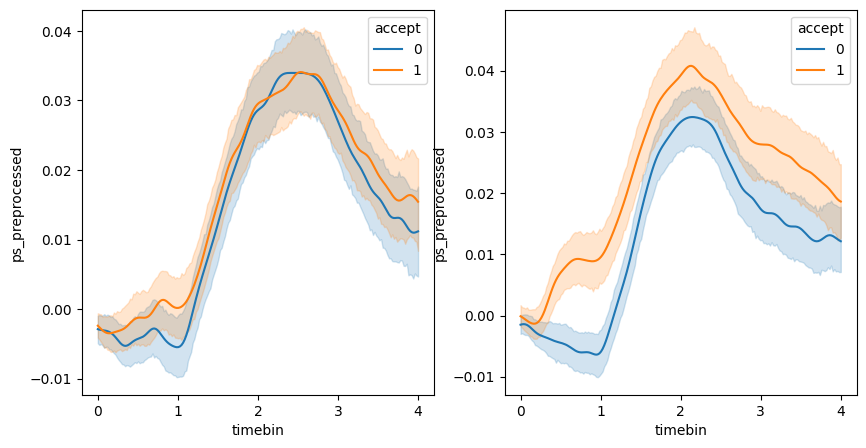

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=data.query("condition == 'equalRange' & (response_int == 2 | response_int == 3)"), x='timebin', y='ps_preprocessed', hue='accept', ax=axs[0])
sns.lineplot(data=data.query("condition == 'equalRange' & (response_int == 1 | response_int == 4)"), x='timebin', y='ps_preprocessed', hue='accept', ax=axs[1])

plt.show()

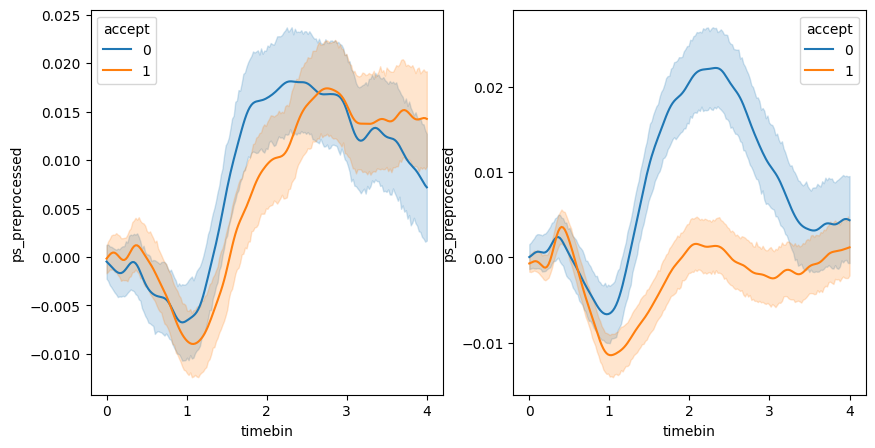

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=data.query("condition == 'equalIndifference' & (response_int == 2 | response_int == 3)"), x='timebin', y='ps_preprocessed', hue='accept', ax=axs[0])
sns.lineplot(data=data.query("condition == 'equalIndifference' & (response_int == 1 | response_int == 4)"), x='timebin', y='ps_preprocessed', hue='accept', ax=axs[1])

plt.show()

<Axes: xlabel='timebin', ylabel='ps_preprocessed'>

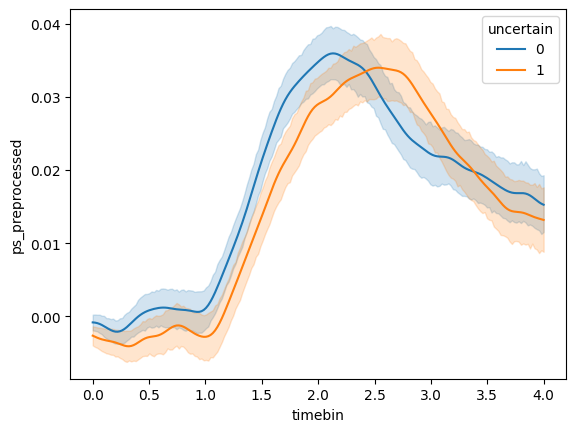

In [27]:
sns.lineplot(data=data.query("condition == 'equalRange'"), x='timebin', y='ps_preprocessed', hue='uncertain')
sns.lineplot(data=data.query("condition == 'equalRange'"), x='timebin', y='ps_preprocessed', hue='uncertain')


<Axes: xlabel='timebin', ylabel='ps_preprocessed'>

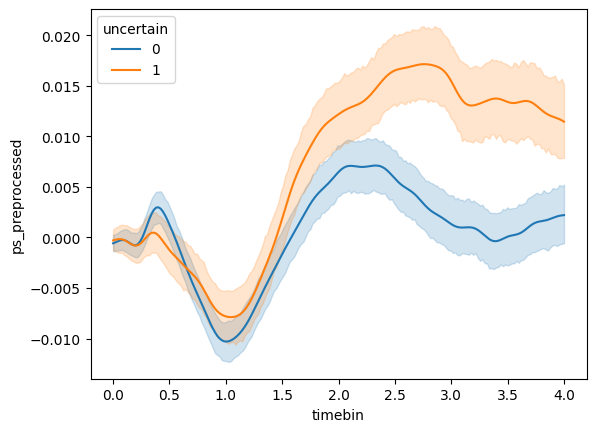

In [28]:
sns.lineplot(data=data.query("condition == 'equalIndifference'"), x='timebin', y='ps_preprocessed', hue='uncertain')
